In [8]:
# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Local imports
from qml.models.multiclass import HybridQuantumMultiClassCNN, BatchedGPUHybridQuantumMultiClassCNN

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load Dataset

In [10]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# MNIST images are 28x28
IMAGE_SIZE = 28  
# Set to an int (e.g., 1000) for quick validation, None for full dataset
LIMIT_SAMPLES = None  

# Transform for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load MNIST dataset
train_dataset_full = datasets.MNIST(root='../data/MNIST', train=True, download=True, transform=transform)
test_dataset_full = datasets.MNIST(root='../data/MNIST', train=False, download=True, transform=transform)

# Limit dataset size if specified
if LIMIT_SAMPLES is not None:
    train_dataset = Subset(train_dataset_full, range(min(LIMIT_SAMPLES, len(train_dataset_full))))
    test_dataset = Subset(test_dataset_full, range(min(LIMIT_SAMPLES // 5, len(test_dataset_full))))
else:
    train_dataset = train_dataset_full
    test_dataset = test_dataset_full

print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")
print(f"Image shape: {train_dataset_full[0][0].shape}")
print(f"Number of classes: {len(train_dataset_full.classes)}")

Training images: 60000
Test images: 10000
Image shape: torch.Size([1, 28, 28])
Number of classes: 10


In [11]:
# DataLoader configuration
BATCH_SIZE = 32

# Create data loaders from the pre-split datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {BATCH_SIZE}")

Train batches: 1875
Test batches: 313
Batch size: 32


## Create Quantum CNN Model

In [ ]:
# Model configuration
from qml.ansatz.dense import DenseQCNNAnsatz

# Select appropriate model class based on device
if device.type == 'cuda':
    print("Selecting BatchedGPUHybridQuantumMultiClassCNN for CUDA acceleration")
    ModelClass = BatchedGPUHybridQuantumMultiClassCNN
else:
    print("Selecting standard HybridQuantumMultiClassCNN")
    ModelClass = HybridQuantumMultiClassCNN

model = ModelClass(
    num_classes=10,
    kernel_size=8,
    stride=4,
    pool_size=8,
    encoding='dense',
    ansatz=DenseQCNNAnsatz(),
    measurement='z',
    trainable_quantum=False
)

model = model.to(device)
print(f"Model output classes: {model.num_classes}")
print(f"Quantum Layer Type: {type(model.qconv).__name__}")

Using default.qubit device with 'dense' encoding, DenseQCNNAnsatz, measurement=PauliZ
Model output classes: 10
Quantum Layer Type: BatchedGPUQuantumConv2D


## Setup Training

In [13]:
from notebooks.multiclass_trainer import MultiClassTrainer

# Training configuration
LEARNING_RATE = 0.005
EPOCHS = 15

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Create trainer
trainer = MultiClassTrainer(
    criterion=criterion,
    device=device,
    max_grad_norm=1.0,
    log_interval=10
)

## Train Model
With test evaluation after each epoch

In [14]:
results = trainer.train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    epochs=EPOCHS,
    test_loader=test_loader
)

Evaluating: 100%|██████████| 313/313 [00:18<00:00, 16.53it/s]


Epoch 1: Train Loss=0.9809, Train Acc=0.6667 | Test Loss=0.6818, Test Acc=0.7700


Evaluating: 100%|██████████| 313/313 [00:19<00:00, 16.01it/s]


Epoch 2: Train Loss=0.7243, Train Acc=0.7574 | Test Loss=0.6001, Test Acc=0.8025


Evaluating: 100%|██████████| 313/313 [00:19<00:00, 16.24it/s]


Epoch 3: Train Loss=0.6735, Train Acc=0.7753 | Test Loss=0.5491, Test Acc=0.8210


Evaluating: 100%|██████████| 313/313 [00:18<00:00, 16.71it/s]


Epoch 4: Train Loss=0.6488, Train Acc=0.7837 | Test Loss=0.5248, Test Acc=0.8254


Evaluating: 100%|██████████| 313/313 [00:18<00:00, 16.78it/s]


Epoch 5: Train Loss=0.6317, Train Acc=0.7893 | Test Loss=0.5359, Test Acc=0.8214


Evaluating: 100%|██████████| 313/313 [00:18<00:00, 17.21it/s]


Epoch 6: Train Loss=0.6226, Train Acc=0.7911 | Test Loss=0.5290, Test Acc=0.8198


Evaluating: 100%|██████████| 313/313 [00:19<00:00, 16.38it/s]


Epoch 7: Train Loss=0.6172, Train Acc=0.7935 | Test Loss=0.5155, Test Acc=0.8289


Evaluating: 100%|██████████| 313/313 [00:19<00:00, 16.39it/s]


Epoch 8: Train Loss=0.6112, Train Acc=0.7950 | Test Loss=0.5184, Test Acc=0.8257


Evaluating: 100%|██████████| 313/313 [00:18<00:00, 16.90it/s]


Epoch 9: Train Loss=0.6062, Train Acc=0.7990 | Test Loss=0.5247, Test Acc=0.8249


Evaluating: 100%|██████████| 313/313 [00:18<00:00, 16.57it/s]


Epoch 10: Train Loss=0.6028, Train Acc=0.7973 | Test Loss=0.5293, Test Acc=0.8230


Evaluating: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s]


Epoch 11: Train Loss=0.5986, Train Acc=0.7987 | Test Loss=0.4943, Test Acc=0.8351


Evaluating: 100%|██████████| 313/313 [00:19<00:00, 16.35it/s]


Epoch 12: Train Loss=0.5976, Train Acc=0.7995 | Test Loss=0.4872, Test Acc=0.8382


Evaluating: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s]


Epoch 13: Train Loss=0.5904, Train Acc=0.8008 | Test Loss=0.4959, Test Acc=0.8331


Evaluating: 100%|██████████| 313/313 [00:18<00:00, 16.83it/s]


Epoch 14: Train Loss=0.5869, Train Acc=0.8028 | Test Loss=0.4901, Test Acc=0.8359


Evaluating: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s]

Epoch 15: Train Loss=0.5857, Train Acc=0.8038 | Test Loss=0.5044, Test Acc=0.8313


## Train results

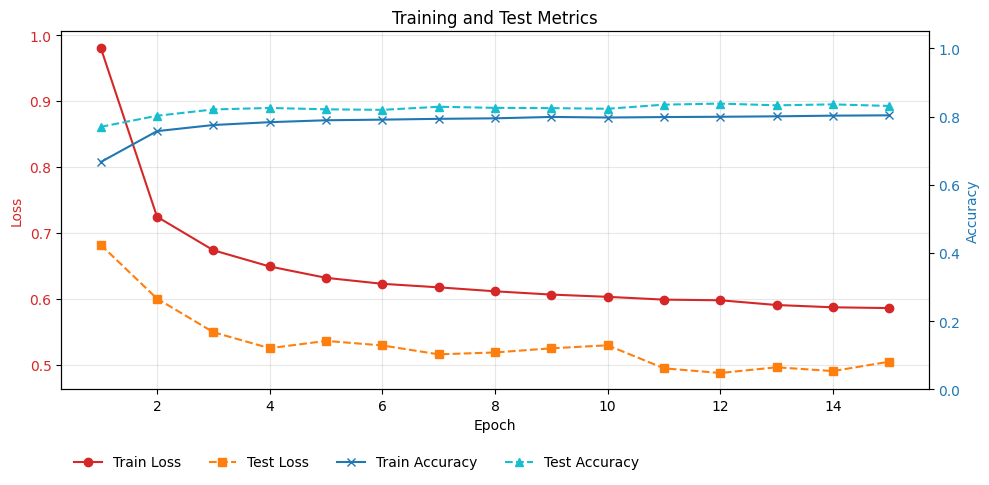

In [17]:
from notebooks.utils import plot_loss_and_accuracy

plot_loss_and_accuracy(
    losses=results['train_loss'],
    accuracies=results['train_acc'],
    test_losses=results['test_loss'],
    test_accuracies=results['test_acc']
)

Evaluating: 100%|██████████| 313/313 [00:19<00:00, 16.11it/s]



Final Test Results:
Test Loss: 0.5044
Test Accuracy: 0.8313


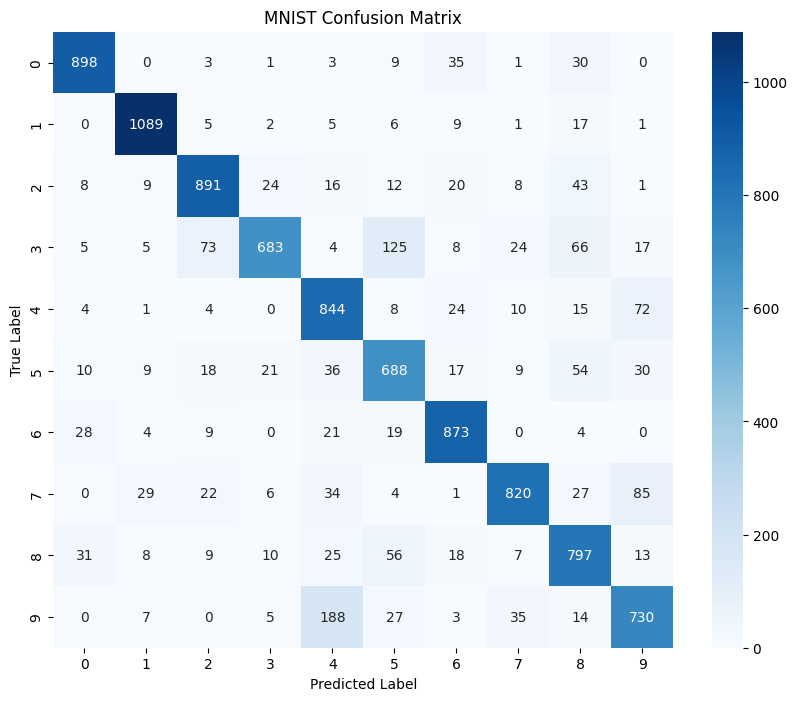


Per-Class Metrics:
Class    Precision    Recall       F1-Score    
------------------------------------------------
0        0.9126       0.9163       0.9145      
1        0.9380       0.9595       0.9486      
2        0.8617       0.8634       0.8625      
3        0.9082       0.6762       0.7753      
4        0.7177       0.8595       0.7822      
5        0.7212       0.7713       0.7454      
6        0.8661       0.9113       0.8881      
7        0.8962       0.7977       0.8441      
8        0.7470       0.8183       0.7810      
9        0.7692       0.7235       0.7457      

Overall Accuracy: 0.8313


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluate on test set
(test_loss, test_acc), confusion_matrix = trainer.evaluate(model, test_loader)

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Plot confusion matrix for 10 classes
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(i) for i in range(10)], 
            yticklabels=[str(i) for i in range(10)])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('MNIST Confusion Matrix')
plt.show()

# Calculate per-class metrics
print(f"\nPer-Class Metrics:")
print(f"{'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 48)

for i in range(10):
    tp = confusion_matrix[i, i]
    fp = confusion_matrix[:, i].sum() - tp
    fn = confusion_matrix[i, :].sum() - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{i:<8} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f}")

# Overall metrics
total_correct = np.trace(confusion_matrix)
total_samples = confusion_matrix.sum()
print(f"\nOverall Accuracy: {total_correct / total_samples:.4f}")